### Bayesian Statistics

Bayesian models combine prior insights with insights from observed data to form updated, posterior insights about a parameter.
Bayesian approach are very flexible, produces clear and direct inferences, and  makes use of all available information.


Advantages:

1.Applicable with a smaller data points 

2.Usage of prior intuitions (from pre-existing observations/models)  on the  posterior resluts 

3.Having high levels of uncertainty, or a strong need to quantify the level of uncertainty about a particular model or comparison of models

4.Wanting to claim something about the likelihood of the alternative hypothesis, rather than simply accepting/rejecting the null hypothesis


Disadvantages:

1.Lack of enough experience on the application of Bayesian models on the 'big data' applications 


2.Sampling posterior distributions in Bayesian models is computationally expensive and slow .




Computational details:
In this example I have used JAGS package. It stands for Just Another Gibbs Sampler. It is a program for analysis of Bayesian hierarchical models using Markov Chain Monte Carlo (MCMC) simulation.




In [ ]:
library(rstanarm)
library("rjags")
options(mc.cores = parallel::detectCores())
library(loo)
library(tidyverse)
library(bayesplot)
library(projpred)
library(fivethirtyeight)
SEED=150702646

### candy_rankings
The raw data behind the story "The Ultimate Halloween Candy Power Ranking


### Format

A data frame with 85 rows representing Halloween candy and 13 variables:

### competitorname

The name of the Halloween candy.

### chocolate
Does it contain chocolate?

### fruity
Is it fruit flavored?

### caramel
Is there caramel in the candy?

### peanutyalmondy
Does it contain peanuts, peanut butter or almonds?

### nougat
Does it contain nougat?

### crispedricewafer
Does it contain crisped rice, wafers, or a cookie component?

### hard
Is it a hard candy?

### bar
Is it a candy bar?

### pluribus
Is it one of many candies in a bag or box?

### sugarpercent
The percentile of sugar it falls under within the data set.

### pricepercent
The unit price percentile compared to the rest of the set.

### winpercent
The overall win percentage according to 269,000 matchups.

In [244]:
dfr <- candy_rankings %>% select(-competitorname)


In [245]:
df2 <- select(candy_rankings,-competitorname)

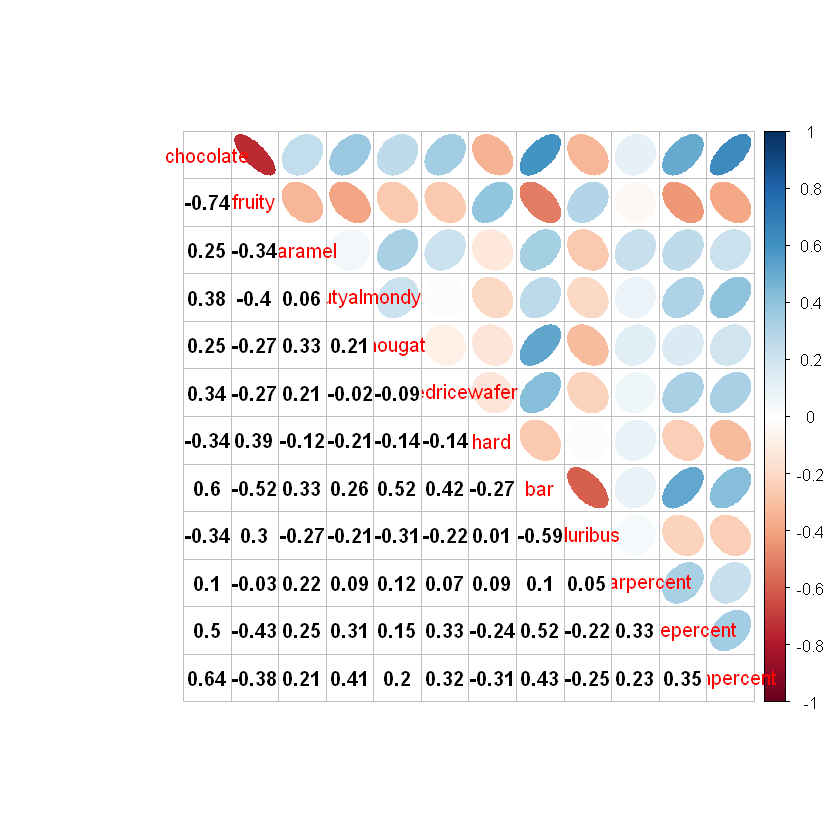

In [246]:
library("corrplot")
Cor = cor(df2)
corrplot(Cor, type="upper", method="ellipse", tl.pos="d")
corrplot(Cor, type="lower", method="number", col="black",
add=TRUE, diag=FALSE, tl.pos="n", cl.pos="n")

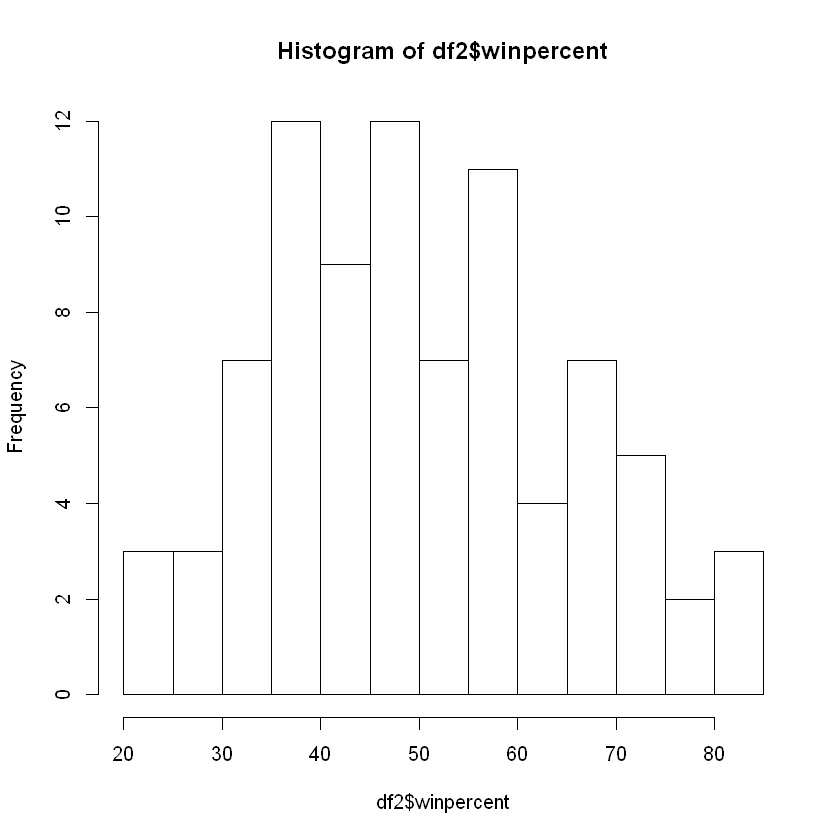

In [273]:
hist(df2$winpercent, breaks=20)

In [274]:
mod5_string <- " model{
  for(i in 1:n){
    y[i]   ~ dnorm(mu[i],prec)
    mu[i] = b[1] + b[2]*chocolate[i] + b[3]*fruity[i] + b[4]*caramel[i] + b[5]*peanutyalmondy[i] +
    b[6]*nougat[i] + b[7]*bar[i]+ b[8]*sugarpercent[i]+ b[9]*pricepercent[i]
  }

  
  for (j in 1:9) {
    b[j] ~ ddexp(0.0, 1.0/1.0e6)
  }
 
 prec ~ dgamma(5/2.0, 5*10.0/2.0)
 sig2 = 1.0 / prec
 sig = sqrt(sig2)

}"


set.seed(83)


data1_jags = list(y=df2$winpercent, chocolate=df2$chocolate,  fruity=df2$fruity, caramel=df2$caramel
                  , peanutyalmondy=df2$peanutyalmondy, nougat=df2$nougat, bar=df2$bar,
                  sugarpercent=df2$sugarpercent, pricepercent=df2$pricepercent, n=nrow(df2))
params1 = c("b", "sig")

inits1 = function() {
    inits = list("b"=rnorm(9,0.0,100.0), "prec"=rgamma(1,1.0,1.0))
}

mod1 = jags.model(textConnection(mod5_string), data=data1_jags, inits=inits1, n.chains=3)
update(mod1, 1e3)
mod1_sim = coda.samples(model=mod1, variable.names =params1, n.iter=7e3)

mod1_csim = do.call(rbind, mod1_sim)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 85
   Unobserved stochastic nodes: 10
   Total graph size: 939

Initializing model



In [275]:
summary(mod1_sim)


Iterations = 2001:9000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 7000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean     SD Naive SE Time-series SE
b[1] 33.223 3.8437 0.026524       0.138318
b[2] 20.664 3.9253 0.027087       0.104686
b[3]  8.193 3.7832 0.026107       0.113905
b[4]  3.292 3.5724 0.024652       0.045370
b[5]  9.495 3.5975 0.024825       0.045094
b[6] -2.722 5.2596 0.036295       0.075278
b[7]  4.138 4.1360 0.028541       0.075733
b[8]  7.621 4.5193 0.031186       0.103923
b[9] -4.493 5.3034 0.036597       0.137881
sig  10.713 0.8578 0.005919       0.007416

2. Quantiles for each variable:

         2.5%     25%    50%     75%  97.5%
b[1]  25.6965 30.6608 33.216 35.7696 40.916
b[2]  13.0448 18.0070 20.629 23.2562 28.514
b[3]   0.7601  5.6758  8.176 10.7105 15.730
b[4]  -3.7551  0.8822  3.272  5.6798 10.334
b[5]   2.3708  7.1294  9.519 11.8803 16.522
b[6] -13.0017 -6.2777 -2.721  0.

In [251]:
mod5_string <- " model{
  for(i in 1:n){
    y[i]   ~ dnorm(mu[i],prec)
    mu[i] = b[1] + b[2]*chocolate[i] + b[3]*fruity[i] + b[4]*caramel[i] + b[5]*peanutyalmondy[i] +
    b[6]*nougat[i] + b[7]*bar[i]+ b[8]*sugarpercent[i]+ b[9]*pricepercent[i]
  }

  
  for (j in 1:9) {
    b[j] ~ dnorm(0.0, 1.0/1.0e6)
  }
 
 prec ~ dgamma(5/2.0, 5*10.0/2.0)
 sig2 = 1.0 / prec
 sig = sqrt(sig2)

}"


set.seed(83)


data1_jags = list(y=df2$winpercent, chocolate=df2$chocolate,  fruity=df2$fruity, caramel=df2$caramel
                  , peanutyalmondy=df2$peanutyalmondy, nougat=df2$nougat, bar=df2$bar,
                  sugarpercent=df2$sugarpercent, pricepercent=df2$pricepercent, n=nrow(df2))
params1 = c("b", "sig")

inits1 = function() {
    inits = list("b"=rnorm(9,0.0,100.0), "prec"=rgamma(1,1.0,1.0))
}

mod1 = jags.model(textConnection(mod5_string), data=data1_jags, inits=inits1, n.chains=3)
update(mod1, 1e3)
mod1_sim = coda.samples(model=mod1, variable.names =params1, n.iter=7e3)

mod1_csim = do.call(rbind, mod1_sim)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 85
   Unobserved stochastic nodes: 10
   Total graph size: 939

Initializing model



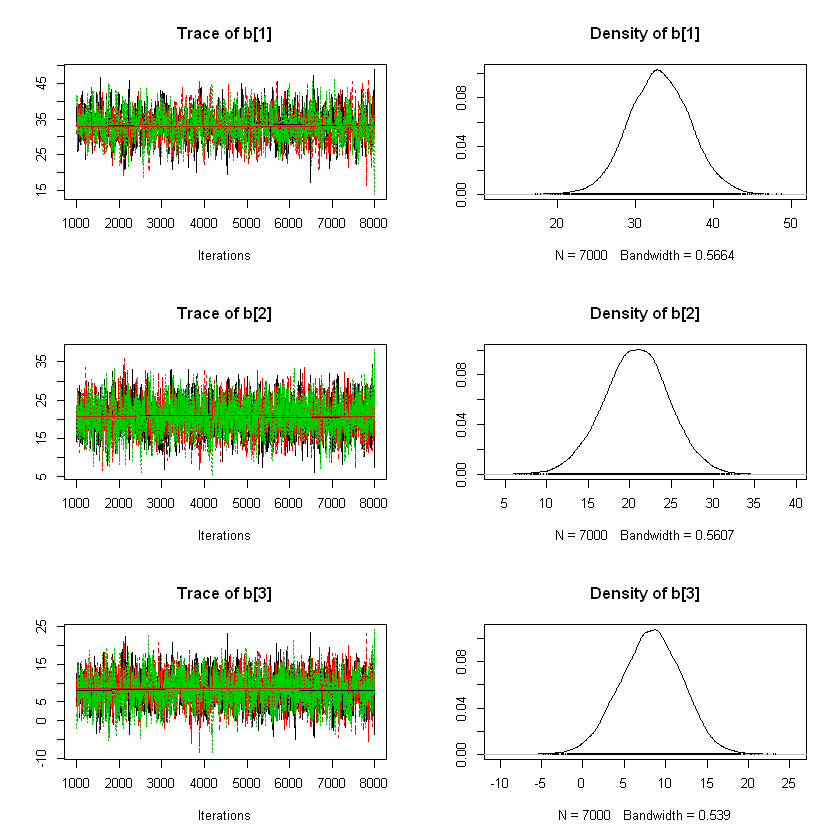

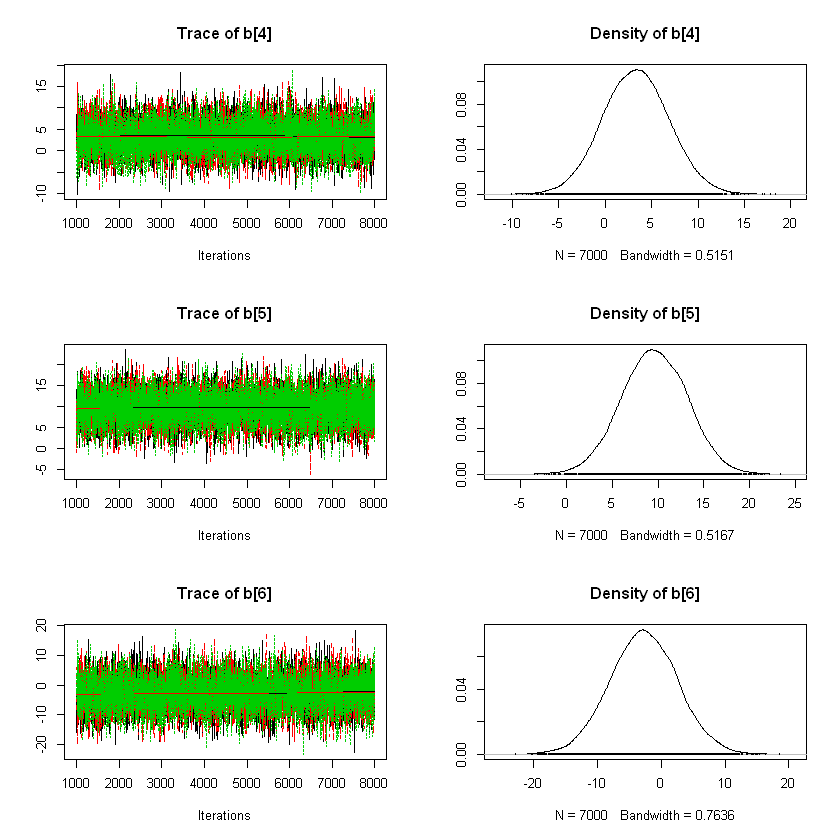

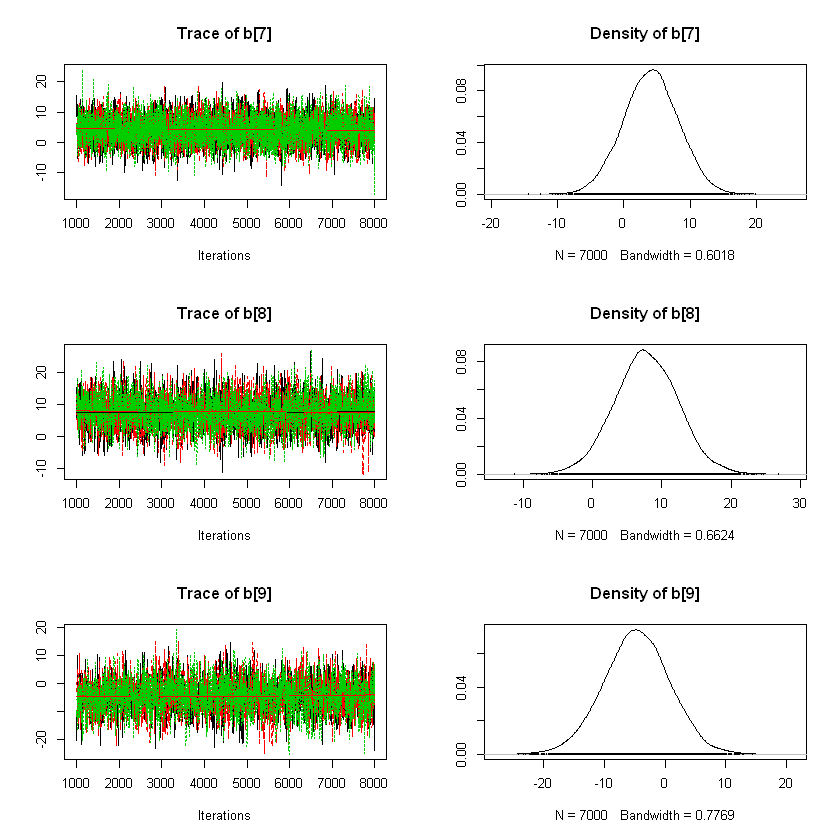

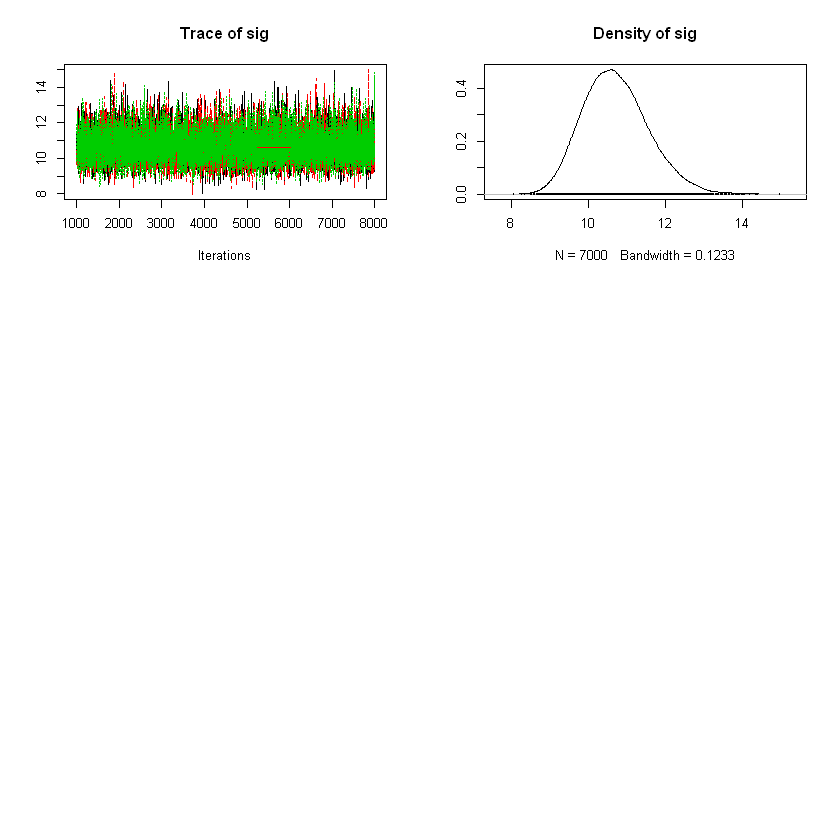

In [252]:
plot(mod1_sim)

In [253]:
gelman.diag(mod1_sim)

Potential scale reduction factors:

     Point est. Upper C.I.
b[1]          1          1
b[2]          1          1
b[3]          1          1
b[4]          1          1
b[5]          1          1
b[6]          1          1
b[7]          1          1
b[8]          1          1
b[9]          1          1
sig           1          1

Multivariate psrf

1

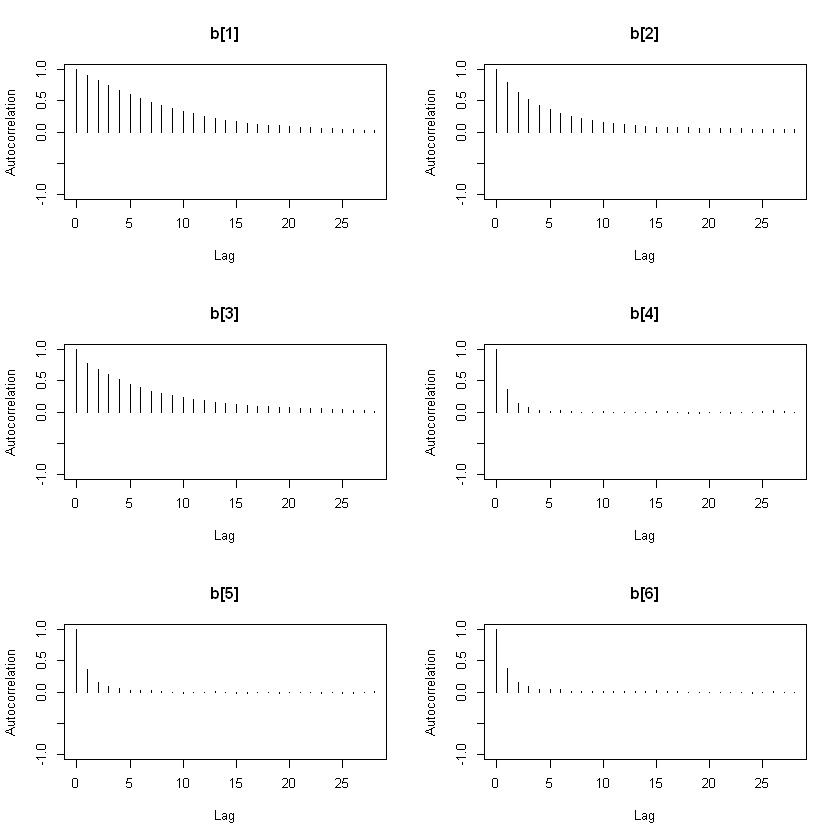

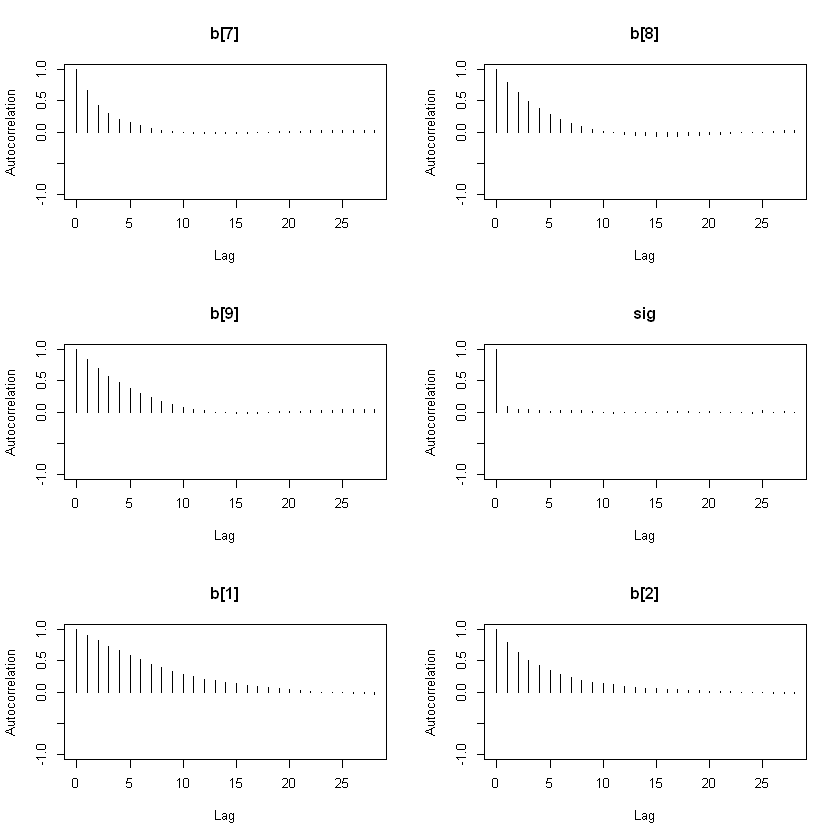

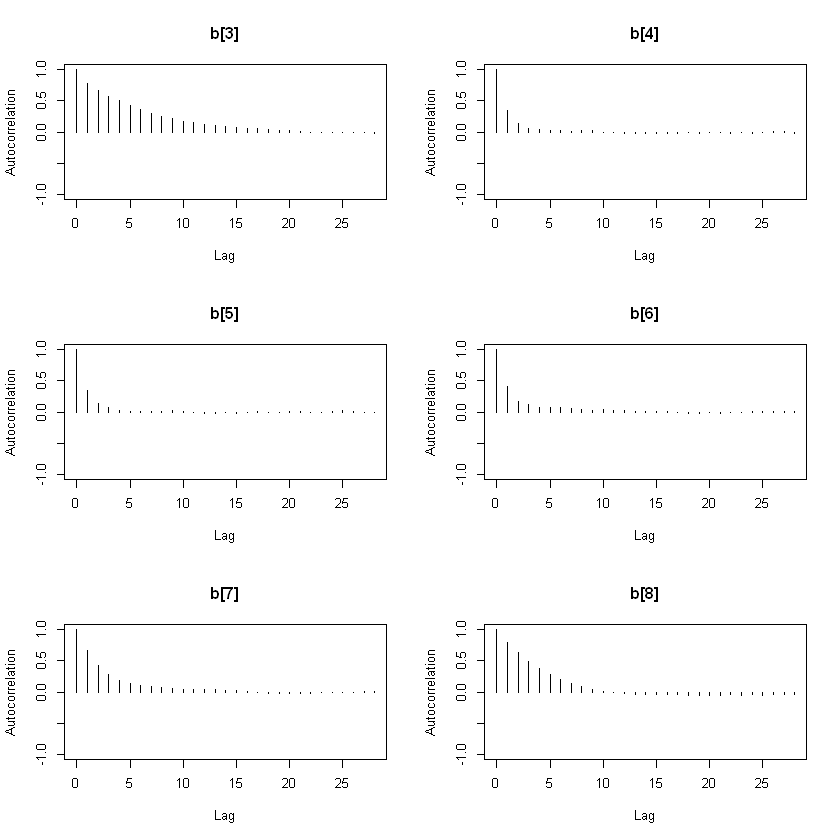

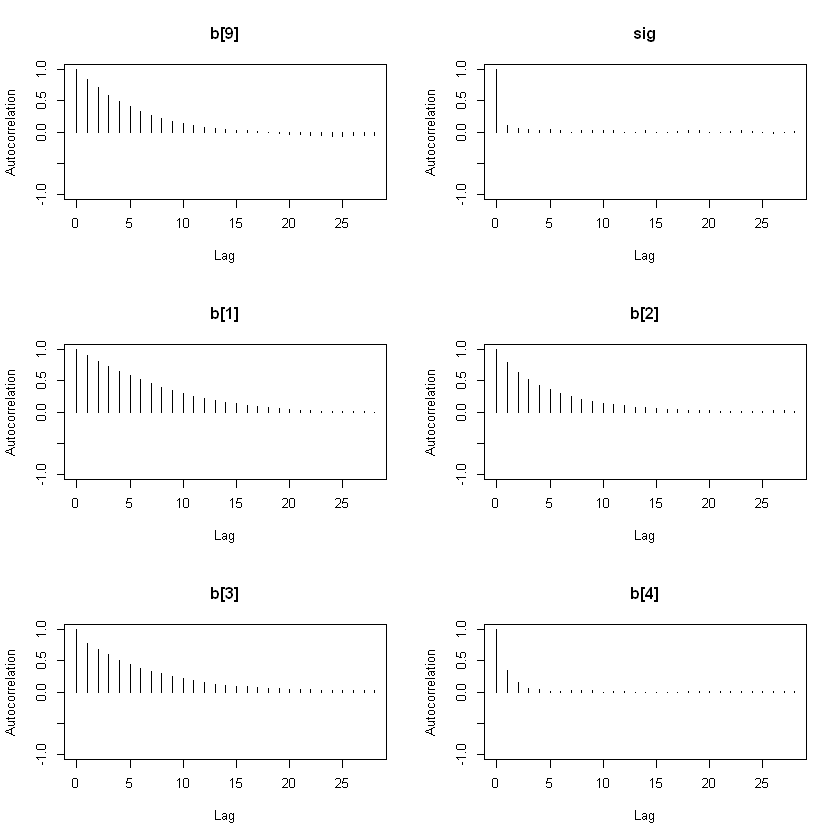

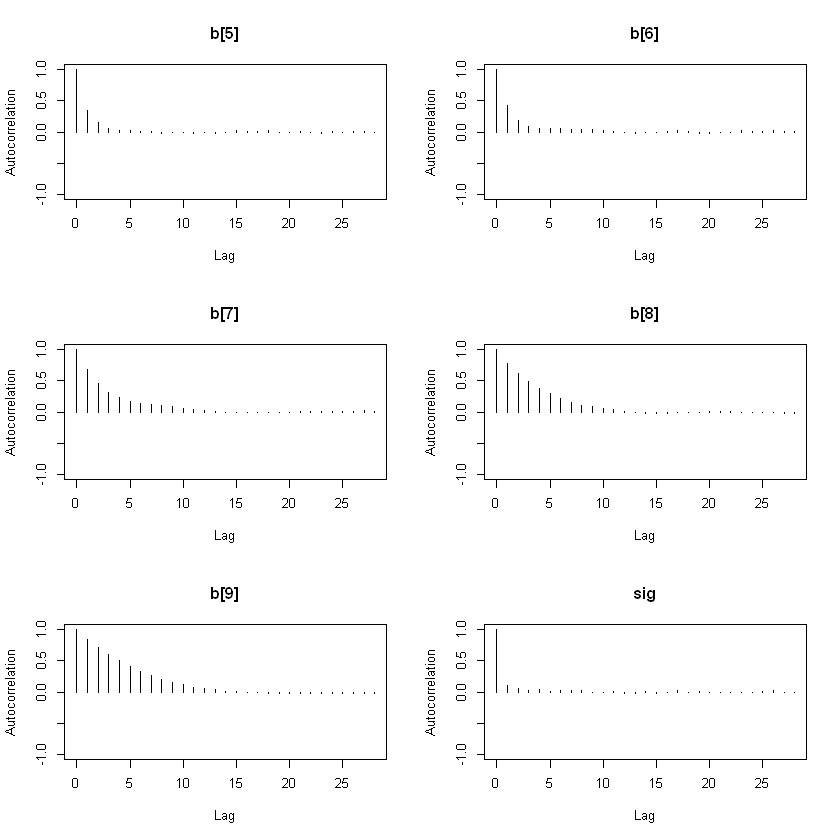

In [254]:
autocorr.plot(mod1_sim)

In [255]:
effectiveSize(mod1_sim)

b[1]      b[2]      b[3]      b[4]      b[5]      b[6]      b[7]      b[8] 
 1185.134  2251.571  1677.697  9792.575  9156.516  7448.538  3905.020  2797.172 
     b[9]       sig 
 2118.052 13367.151

I ran the chain for 5000 iterations and we had 3 different chains. So we should have 15000 samples. These resluts show that how many samples have used to the calculations.

In [256]:
summary(mod1_sim)


Iterations = 1001:8000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 7000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean    SD Naive SE Time-series SE
b[1] 33.127 3.911 0.026988       0.114234
b[2] 20.771 3.924 0.027081       0.082808
b[3]  8.284 3.721 0.025680       0.091002
b[4]  3.312 3.557 0.024543       0.035940
b[5]  9.597 3.568 0.024621       0.037331
b[6] -2.696 5.272 0.036382       0.061566
b[7]  4.106 4.165 0.028739       0.066954
b[8]  7.737 4.609 0.031802       0.087268
b[9] -4.647 5.441 0.037545       0.118988
sig  10.704 0.852 0.005879       0.007371

2. Quantiles for each variable:

         2.5%     25%    50%     75%  97.5%
b[1]  25.4821 30.4840 33.100 35.7690 40.877
b[2]  12.9590 18.1927 20.818 23.3807 28.449
b[3]   0.9045  5.7923  8.338 10.8308 15.367
b[4]  -3.5964  0.8986  3.294  5.6870 10.350
b[5]   2.5522  7.1794  9.593 12.0531 16.503
b[6] -12.9877 -6.2352 -2.696  0.8749  7.786

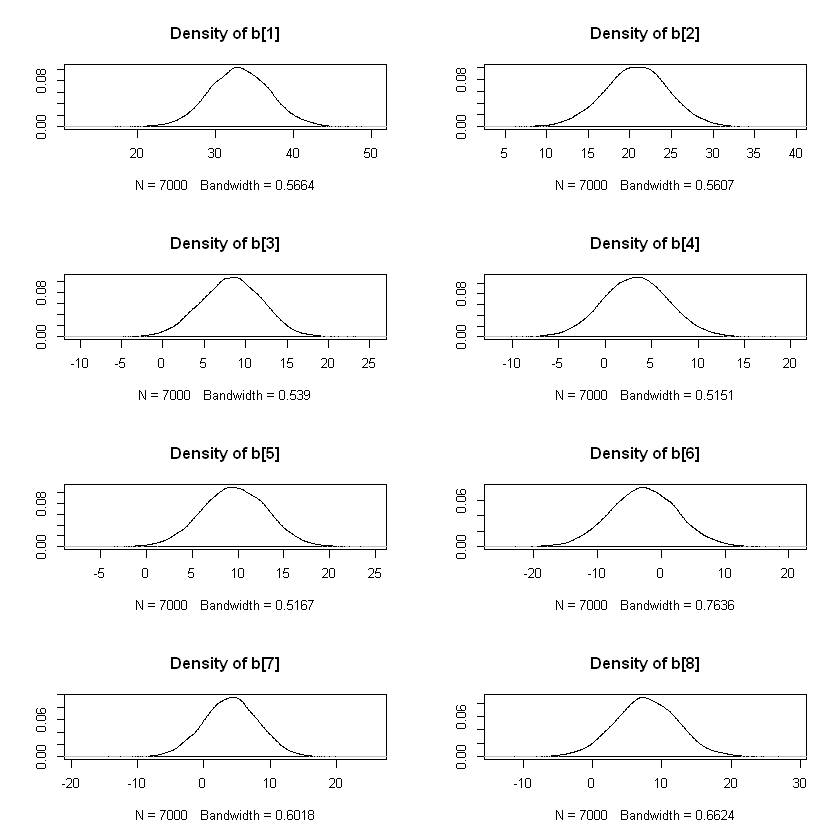

In [257]:
par(mfrow=c(4,2))
densplot(mod1_sim[,1:8])

In [212]:
gelman.diag(mod1_sim)

Potential scale reduction factors:

     Point est. Upper C.I.
b[1]       1.01       1.02
b[2]       1.00       1.01
b[3]       1.01       1.02
b[4]       1.00       1.01
b[5]       1.00       1.00
b[6]       1.00       1.00
b[7]       1.00       1.01
b[8]       1.00       1.00
b[9]       1.00       1.00
sig        1.00       1.00

Multivariate psrf

1.01

The potential scale reduction factor fot the 9 parameters are cose to 1 indicating that our results are converged.

In [202]:
(pm_params = colMeans(mod1_csim))

b[1]      b[2]      b[3]      b[4]      b[5]      b[6]      b[7]      b[8] 
33.220946 20.733636  8.176731  3.319653  9.457293 -2.770263  4.178138  7.830190 
     b[9]       sig 
-4.782320 10.726534

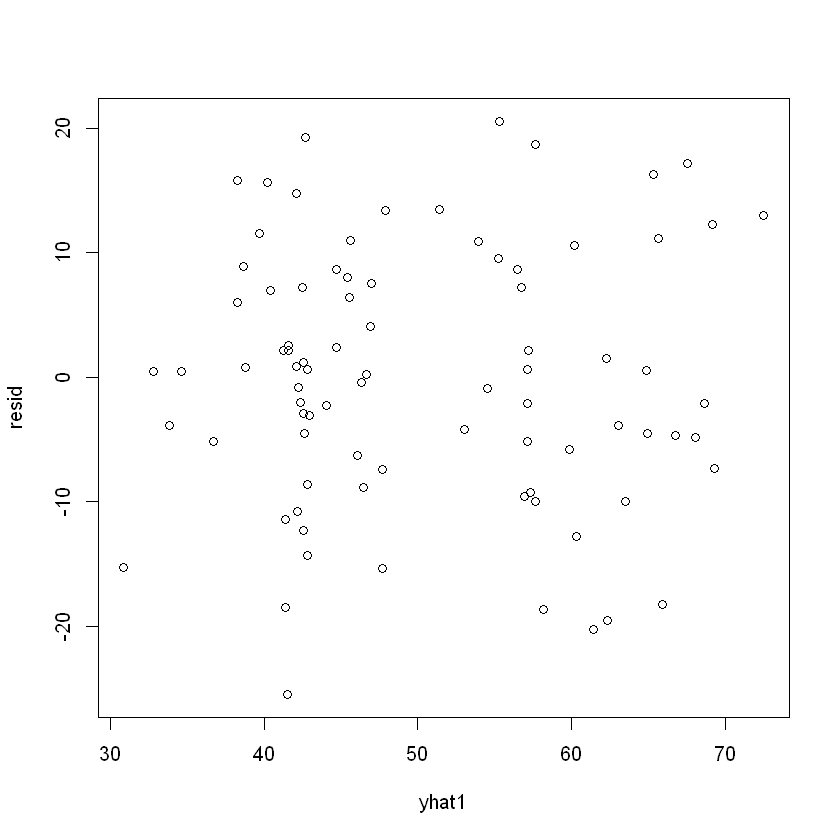

In [224]:
yhat = pm_params[1] + as.matrix(df2[,c(1,2,3,4,5,8,10,11)]) %*% pm_params[2:9]
yhat1 = drop(yhat)
resid= yhat1- drop(df2$winpercent)
plot(yhat1, resid)

Since we do not see any pattern in this plot it mean that the data points are independent from each other.  They approximately have a mean of 0.

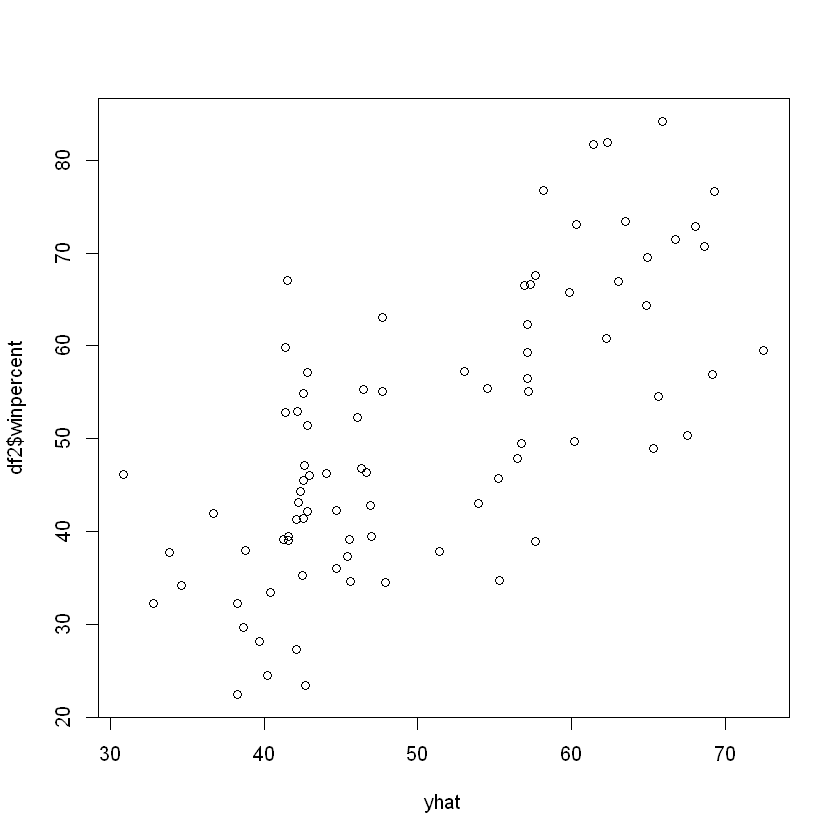

In [216]:
plot(yhat,df2$winpercent)